# 3D CNN

Basic + Batch Norm + Augmentations

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 792379571013149
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../tmp\logs\20210308-091048
Wall time: 0 ns


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20210308-091048
checkpoint dir: ../../../tmp\checkpoints\20210308-091048
log dir: ../../../tmp\logs\20210308-091048
loading ../../../tmp\data-v3\train_x.npy, ../../../tmp\data-v3\train_y.npy...
loading ../../../tmp\data-v3\val_x.npy, ../../../tmp\data-v3\val_y.npy...
training...
Epoch 1/150
51/51 [==============================] - ETA: 0s - loss: 1.7081 - recall: 0.5249 - precision: 0.5249 - auc: 0.5386 - categorical_accuracy: 0.5249
Epoch 00001: val_auc improved from -inf to 0.31900, saving model to ../../../tmp\checkpoints\20210308-091048\cp-0001.ckpt
51/51 [==============================] - 25s 498ms/step - loss: 1.7081 - recall: 0.5249 - precision: 0.5249 - auc: 0.5386 - categorical_accuracy: 0.5249 - val_loss: 0.8231 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.3190 - val_categorical_accuracy: 0.3800
Epoch 2/150
51/51 [==============================] - ETA: 0s - loss: 1.0968 - recall: 0.5423 - precision: 0.5423 - auc: 0.5811 - categorical_accuracy: 0.5423
E

Epoch 32/150
51/51 [==============================] - ETA: 0s - loss: 0.3103 - recall: 0.9229 - precision: 0.9229 - auc: 0.9805 - categorical_accuracy: 0.9229
Epoch 00032: val_auc did not improve from 0.80000
51/51 [==============================] - 24s 461ms/step - loss: 0.3103 - recall: 0.9229 - precision: 0.9229 - auc: 0.9805 - categorical_accuracy: 0.9229 - val_loss: 0.6412 - val_recall: 0.5700 - val_precision: 0.5700 - val_auc: 0.6252 - val_categorical_accuracy: 0.5700
Epoch 33/150
51/51 [==============================] - ETA: 0s - loss: 0.3049 - recall: 0.9279 - precision: 0.9279 - auc: 0.9796 - categorical_accuracy: 0.9279
Epoch 00033: val_auc did not improve from 0.80000
51/51 [==============================] - 24s 465ms/step - loss: 0.3049 - recall: 0.9279 - precision: 0.9279 - auc: 0.9796 - categorical_accuracy: 0.9279 - val_loss: 0.6481 - val_recall: 0.5500 - val_precision: 0.5500 - val_auc: 0.6177 - val_categorical_accuracy: 0.5500
Epoch 34/150
51/51 [======================

51/51 [==============================] - ETA: 0s - loss: 0.2565 - recall: 0.9776 - precision: 0.9776 - auc: 0.9947 - categorical_accuracy: 0.9776
Epoch 00065: val_auc did not improve from 0.81790
51/51 [==============================] - 24s 464ms/step - loss: 0.2565 - recall: 0.9776 - precision: 0.9776 - auc: 0.9947 - categorical_accuracy: 0.9776 - val_loss: 0.5429 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8169 - val_categorical_accuracy: 0.7400
Epoch 66/150
51/51 [==============================] - ETA: 0s - loss: 0.2645 - recall: 0.9726 - precision: 0.9726 - auc: 0.9957 - categorical_accuracy: 0.9726
Epoch 00066: val_auc did not improve from 0.81790
51/51 [==============================] - 24s 464ms/step - loss: 0.2645 - recall: 0.9726 - precision: 0.9726 - auc: 0.9957 - categorical_accuracy: 0.9726 - val_loss: 0.5418 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.8146 - val_categorical_accuracy: 0.7500
Epoch 67/150
51/51 [==============================] - E

Epoch 82/150
51/51 [==============================] - ETA: 0s - loss: 0.2522 - recall: 0.9701 - precision: 0.9701 - auc: 0.9955 - categorical_accuracy: 0.9701
Epoch 00082: val_auc did not improve from 0.81850
51/51 [==============================] - 24s 465ms/step - loss: 0.2522 - recall: 0.9701 - precision: 0.9701 - auc: 0.9955 - categorical_accuracy: 0.9701 - val_loss: 0.5415 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8173 - val_categorical_accuracy: 0.7400
Epoch 83/150
51/51 [==============================] - ETA: 0s - loss: 0.2454 - recall: 0.9751 - precision: 0.9751 - auc: 0.9981 - categorical_accuracy: 0.9751
Epoch 00083: val_auc did not improve from 0.81850
51/51 [==============================] - 23s 461ms/step - loss: 0.2454 - recall: 0.9751 - precision: 0.9751 - auc: 0.9981 - categorical_accuracy: 0.9751 - val_loss: 0.5414 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.8170 - val_categorical_accuracy: 0.7500
Epoch 84/150
51/51 [======================

Epoch 99/150
51/51 [==============================] - ETA: 0s - loss: 0.2534 - recall: 0.9602 - precision: 0.9602 - auc: 0.9942 - categorical_accuracy: 0.9602
Epoch 00099: val_auc did not improve from 0.81920
51/51 [==============================] - 24s 464ms/step - loss: 0.2534 - recall: 0.9602 - precision: 0.9602 - auc: 0.9942 - categorical_accuracy: 0.9602 - val_loss: 0.5421 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8191 - val_categorical_accuracy: 0.7400
Epoch 100/150
51/51 [==============================] - ETA: 0s - loss: 0.2543 - recall: 0.9652 - precision: 0.9652 - auc: 0.9961 - categorical_accuracy: 0.9652
Epoch 00100: val_auc did not improve from 0.81920
51/51 [==============================] - 24s 462ms/step - loss: 0.2543 - recall: 0.9652 - precision: 0.9652 - auc: 0.9961 - categorical_accuracy: 0.9652 - val_loss: 0.5421 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8189 - val_categorical_accuracy: 0.7400
Epoch 101/150
51/51 [====================

Epoch 116/150
51/51 [==============================] - ETA: 0s - loss: 0.2485 - recall: 0.9751 - precision: 0.9751 - auc: 0.9956 - categorical_accuracy: 0.9751
Epoch 00116: val_auc improved from 0.81930 to 0.81940, saving model to ../../../tmp\checkpoints\20210308-091048\cp-0116.ckpt
51/51 [==============================] - 24s 468ms/step - loss: 0.2485 - recall: 0.9751 - precision: 0.9751 - auc: 0.9956 - categorical_accuracy: 0.9751 - val_loss: 0.5419 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8194 - val_categorical_accuracy: 0.7400
Epoch 117/150
51/51 [==============================] - ETA: 0s - loss: 0.2487 - recall: 0.9701 - precision: 0.9701 - auc: 0.9963 - categorical_accuracy: 0.9701
Epoch 00117: val_auc did not improve from 0.81940
51/51 [==============================] - 24s 462ms/step - loss: 0.2487 - recall: 0.9701 - precision: 0.9701 - auc: 0.9963 - categorical_accuracy: 0.9701 - val_loss: 0.5419 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8189 

Epoch 133/150
51/51 [==============================] - ETA: 0s - loss: 0.2549 - recall: 0.9701 - precision: 0.9701 - auc: 0.9947 - categorical_accuracy: 0.9701
Epoch 00133: val_auc did not improve from 0.81950
51/51 [==============================] - 24s 465ms/step - loss: 0.2549 - recall: 0.9701 - precision: 0.9701 - auc: 0.9947 - categorical_accuracy: 0.9701 - val_loss: 0.5420 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8190 - val_categorical_accuracy: 0.7400
Epoch 134/150
51/51 [==============================] - ETA: 0s - loss: 0.2537 - recall: 0.9652 - precision: 0.9652 - auc: 0.9957 - categorical_accuracy: 0.9652
Epoch 00134: val_auc did not improve from 0.81950
51/51 [==============================] - 24s 466ms/step - loss: 0.2537 - recall: 0.9652 - precision: 0.9652 - auc: 0.9957 - categorical_accuracy: 0.9652 - val_loss: 0.5421 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.8191 - val_categorical_accuracy: 0.7400
Epoch 135/150
51/51 [===================

## Evaluation

Wall time: 78.9 ms


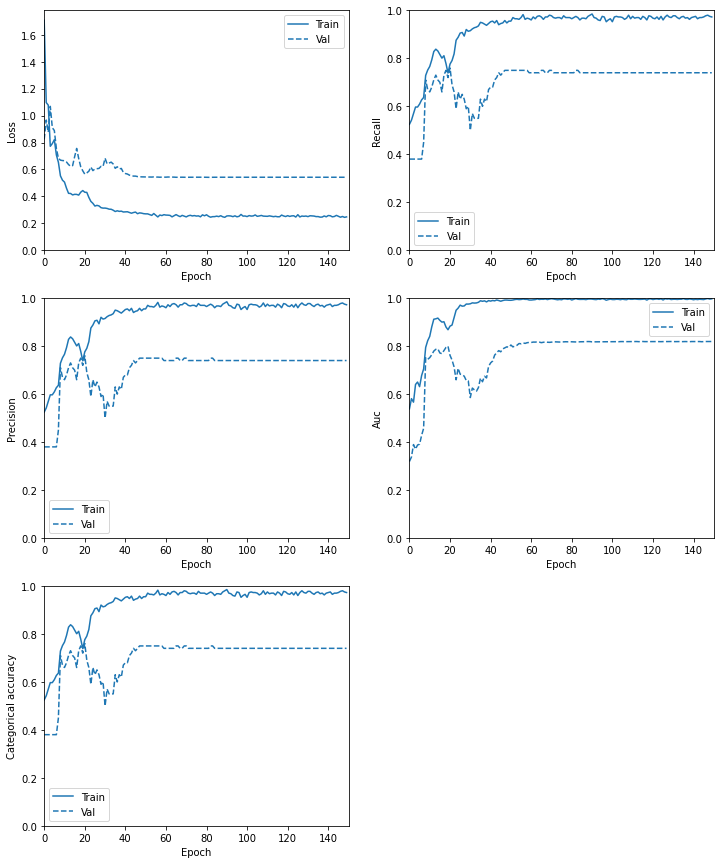

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.5240942239761353
recall: 0.7400000095367432
precision: 0.7400000095367432
auc: 0.8193999528884888
categorical_accuracy: 0.7400000095367432

Wall time: 24.1 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8
recall: 0.7741935483870968
f1-score: 0.7868852459016393
support: 62


CN
precision: 0.65
recall: 0.6842105263157895
f1-score: 0.6666666666666667
support: 38


micro avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


macro avg
precision: 0.7250000000000001
recall: 0.7292020373514432
f1-score: 0.726775956284153
support: 100


weighted avg
precision: 0.743
recall: 0.74
f1-score: 0.7412021857923498
support: 100


samples avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


F1
micro: 0.74
macro: 0.726775956284153


accuracy_score: 0.74
sensitivity_score: 0.7741935483870968
specificity_score: 0.6842105263157895


Wall time: 24.2 s


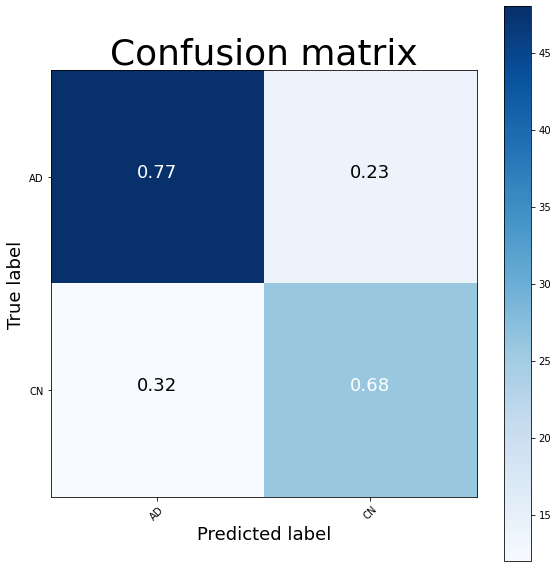

In [11]:
%%time

show_metrics(model, test_seq, class_names)